## Loading necessary libraries

In [1]:
import pandas as pd, numpy as np, pickle
from interactiontransformer.InteractionTransformer import InteractionTransformer, run_shap
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl
import scipy
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")
mpl.rcParams['figure.dpi'] = 300
sns.set(style='white',font_scale=0.5)

Using TensorFlow backend.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of nump

## Loading the data

In [12]:
df=pd.read_csv('../test_data/epistasis.test.csv')
X,y=df.iloc[:,:-1],df.iloc[:,-1]

## Train Test Split

In [13]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,stratify=y,shuffle=True)

## Find the top interactions in the training set

In [ ]:
transformer=InteractionTransformer(max_train_test_samples=1000,mode_interaction_extract=int(np.sqrt(X_train.shape[1]))) # mode_interaction_extract='sqrt'
transformer.fit(X_train,y_train)

## Transform design matrices for training and test sets

In [5]:
X_train2=transformer.transform(X_train)
X_test2=transformer.transform(X_test)

## Extract top ranked interactions via SHAP

In [6]:
transformer.all_interaction_shap_scores.sort_values('shap_interaction_score',ascending=False).iloc[:10]

,feature_1,feature_2,shap_interaction_score
1532,P1_1,P2_1,0.027191
1531,P1_1,P2_0,0.022998
1528,P1_0,P2_1,0.018854
1527,P1_0,P2_0,0.017997
1238,N11_1,P2_1,0.004296
712,N5_0,N17_1,0.003068
1229,N11_1,N16_1,0.003035
1206,N11_0,N17_0,0.003008
420,N3_0,N6_0,0.002960
725,N5_1,N7_1,0.002794


## Fit Models and then get AUROC

In [7]:
lr=LogisticRegression(random_state=42,class_weight='balanced').fit(X_train,y_train)
lr2=LogisticRegression(random_state=42,class_weight='balanced').fit(X_train2,y_train)
rf=BalancedRandomForestClassifier(random_state=42).fit(X_train,y_train)

print(roc_auc_score(y_test,lr.predict_proba(X_test)[:,-1]))
print(roc_auc_score(y_test,lr2.predict_proba(X_test2)[:,-1]))
print(roc_auc_score(y_test,rf.predict_proba(X_test)[:,-1]))

0.47324999999999995
0.8470750000000001
0.7993


## Collect SHAP Feature Importances

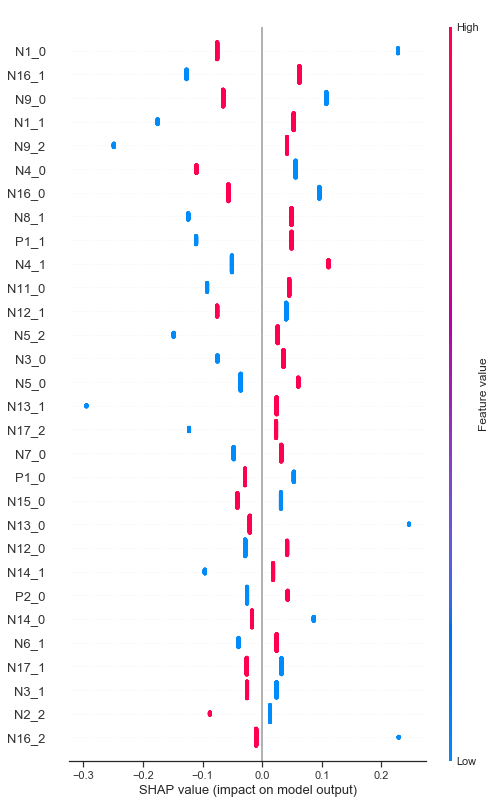

<Figure size 432x288 with 0 Axes>

In [12]:
shap_lr=run_shap(X_train, X_test, lr, model_type='linear', explainer_options={}, get_shap_values_options={}, overall=False, savefile='../test_data/epistasis.lr.shap.png')

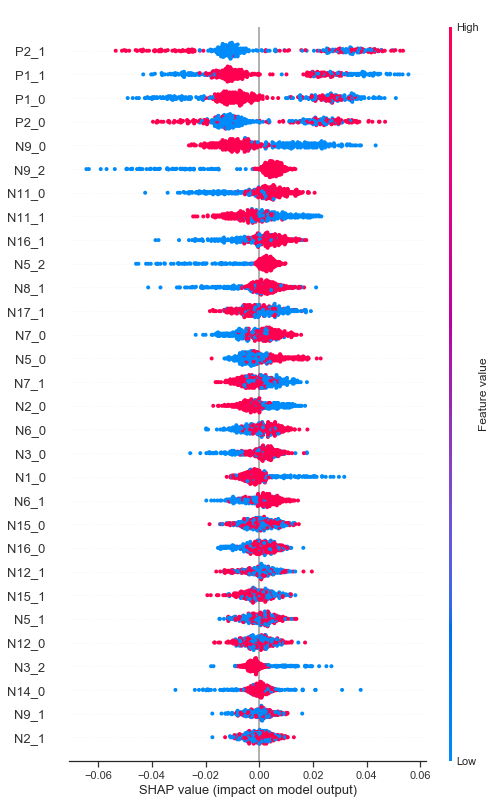

<Figure size 432x288 with 0 Axes>

In [13]:
shap_rf=run_shap(X_train, X_test, rf, model_type='tree', explainer_options={}, get_shap_values_options={}, overall=False, savefile='../test_data/epistasis.rf.shap.png')

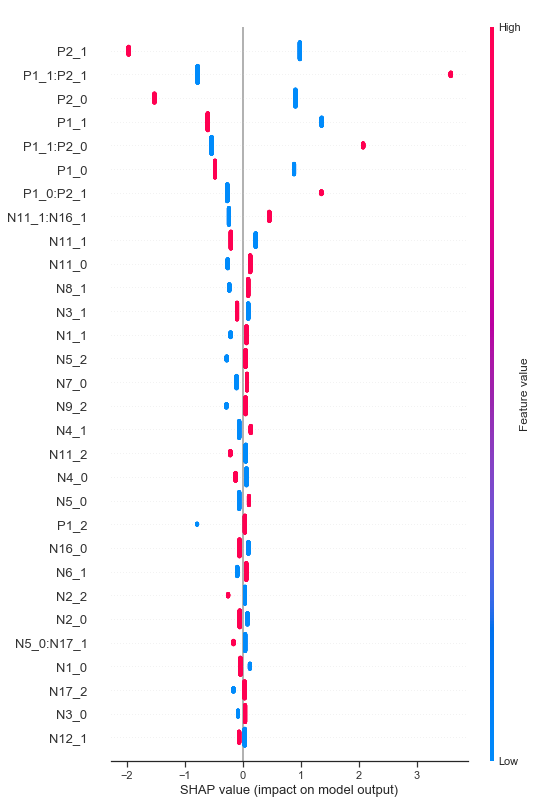

<Figure size 432x288 with 0 Axes>

In [14]:
shap_lr2=run_shap(X_train2, X_test2, lr2, model_type='linear', explainer_options={}, get_shap_values_options={}, overall=False, savefile='../test_data/epistasis.lr2.shap.png')


## XGBoost Example

In [4]:
from xgboost import XGBClassifier
transformer=InteractionTransformer(untrained_model=XGBClassifier(random_state=42),max_train_test_samples=1000,mode_interaction_extract=int(np.sqrt(X_train.shape[1]))) # mode_interaction_extract='sqrt'
transformer.fit(X_train,y_train)

In [5]:
X_train2=transformer.transform(X_train)
X_test2=transformer.transform(X_test)

In [6]:
transformer.all_interaction_shap_scores.sort_values('shap_interaction_score',ascending=False).iloc[:10]

,feature_1,feature_2,shap_interaction_score
1532,P1_1,P2_1,0.243026
1531,P1_1,P2_0,0.049909
1527,P1_0,P2_0,0.035428
484,N3_1,N13_0,0.030417
1132,N9_0,P2_1,0.021511
227,N1_2,N6_1,0.019211
322,N2_1,N5_0,0.018809
283,N2_0,N8_1,0.018747
716,N5_0,P1_2,0.017876
673,N4_2,P1_0,0.017517


In [10]:
xgb=XGBClassifier(random_state=42).fit(X_train,y_train)
lr2=LogisticRegression(random_state=42,class_weight='balanced').fit(X_train2,y_train)

print(roc_auc_score(y_test,xgb.predict_proba(X_test)[:,-1]))
print(roc_auc_score(y_test,lr2.predict_proba(X_test2)[:,-1]))

0.8029249999999999
0.843875


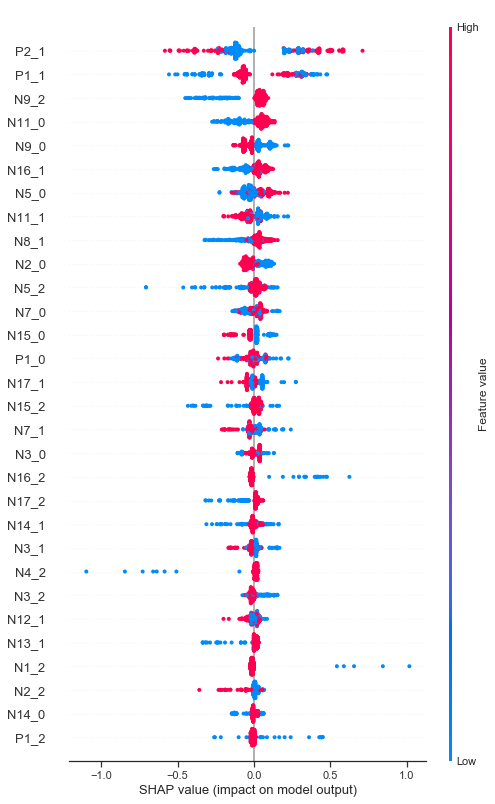

<Figure size 432x288 with 0 Axes>

In [9]:
shap_xgb=run_shap(X_train, X_test, xgb, model_type='tree', explainer_options={}, get_shap_values_options={}, overall=False, savefile='../test_data/epistasis.xgb.shap.png')


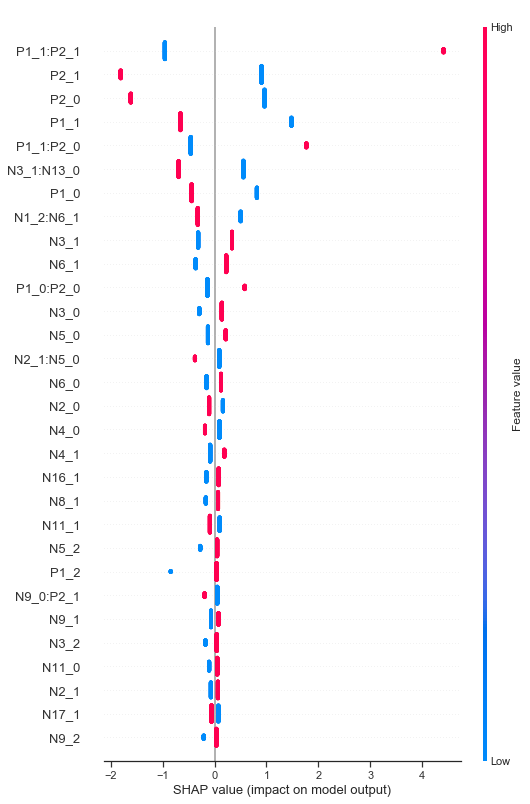

<Figure size 432x288 with 0 Axes>

In [11]:
shap_lr3=run_shap(X_train2, X_test2, lr2, model_type='linear', explainer_options={}, get_shap_values_options={}, overall=False, savefile='../test_data/epistasis.lr2.shap.png')


## Basic Multiclass Example

In [2]:
from sklearn import datasets

iris = datasets.load_iris()
X = pd.DataFrame(iris.data,columns=['sepal_length','sepal_width','petal_length','petal_width'])
y = pd.DataFrame(iris.target,columns=['species'])

In [3]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,stratify=y,shuffle=True)

In [4]:
transformer=InteractionTransformer(max_train_test_samples=1000,mode_interaction_extract=int(np.sqrt(X_train.shape[1])), cv_scoring='f1') 
transformer.fit(X_train,y_train)

ValueError: Must pass 2-d input

In [5]:
import pickle
shap_vals=pickle.load(open('shap_test.pkl','rb'))

In [7]:
shap_vals[0].shape

(1, 4, 4)